# ARIMA Model




An ARIMA model is a class of statistical models for analyzing and forecasting time series data.

It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.

d: The number of times that the raw observations are differenced, also called the degree of differencing.

q: The size of the moving average window, also called the order of moving average

# Box-Jenkins method

1. Box-Jenkins method

Building time series models can represent a lot of work for the modeler and so we want to maximize our ability to carry out these projects fast, efficiently and rigorously. This is where the Box-Jenkins method comes in. The Box-Jenkins method is a kind of checklist for you to go from raw data to a model ready for production. The three main steps that stand between you and a production-ready model are identification, estimation and model diagnostics.
3. Identification

In the identification step we explore and characterize the data to find some form of it which is appropriate to ARIMA modeling. We need to know whether the time series is stationary and find which transformations, such as differencing or taking the log of the data, will make it stationary. Once we have found a stationary form, we must identify which orders p and q are the most promising.
4. Identification tools

Our tools to test for stationarity include plotting the time series and using the augmented Dicky-Fuller test. Then we can take the difference or apply transformations until we find the simplest set of transformations that make the time series stationary. Finally we use the ACF and PACF to identify promising model orders.
5. Estimation

The next step is estimation, which involves using numerical methods to estimate the AR and MA coefficients of the data. Thankfully, this is automatically done for us when we call the model's dot-fit method. At this stage we might fit many models and use the AIC and BIC to narrow down to more promising candidates.
6. Model diagnostics

In the model diagnostics step, we evaluate the quality of the best fitting model. Here is where we use our test statistics and diagnostic plots to make sure the residuals are well behaved.
7. Decision

Using the information gathered from statistical tests and plots during the diagnostic step, we need to make a decision. Is the model good enough or do we need to go back and rework it.
8. Repeat

If the residuals aren't as they should be we will go back and rethink our choices in the earlier steps.
9. Production

If the residuals are okay then we can go ahead and make forecasts!
10. Box-Jenkins

This should be your general project workflow when developing time series models. You may have to repeat the process a few times in order to build a model that fits well. But as they say, no pain, no gain. 

In [55]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime, date 
import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization
# Import augmented dicky-fuller test function
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
# Import Normalizer
from sklearn.preprocessing import Normalizer
import os
import plotly_express as px# Visualization
import plotly.graph_objects as go# Visualization
from plotly.subplots import make_subplots# Visualization
import gc
import warnings # Supress warnings 
# Import data generation function and set random seed
from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api as sm
warnings.filterwarnings('ignore')

In [2]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
    if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)                    
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            elif str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
TrainData= '/home/abderrazak/ALLINHERE/NLP/Datacamp/sag_data_train.csv'
TestData= '/home/abderrazak/ALLINHERE/NLP/Datacamp/sag_data_test.csv'
#df = pd.read_csv(TrainData)
TrainData = pd.read_csv(TrainData, index_col="Time", parse_dates=True)
#df = pd.read_csv(TrainData, index_col='Time', parse_dates=True)
TestData = pd.read_csv(TestData, index_col="Time", parse_dates=True)


In [5]:
TrainData =reduce_mem_usage(TrainData)

Memory usage of dataframe is 7.38 MB
Memory usage after optimization is: 6.59 MB
Decreased by 10.7%


In [6]:
TrainData.shape

(138241, 6)

In [7]:
TestData = reduce_mem_usage(TestData)

Memory usage of dataframe is 1.54 MB
Memory usage after optimization is: 1.37 MB
Decreased by 10.7%


In [8]:
TestData.head(1)

,Bearing Pressure (kPa),Power Draw (MW),Speed (RPM),Dilution Flow Rate (m3/h),Conveyor Belt Feed Rate (t/h),Conveyor Belt PSD Fines (%)
Time,,,,,,
2015-12-21,5364.649789,12.762004,8.073871,1073.169397,2940.881221,40.375


In [9]:
TestData.head(1)

,Bearing Pressure (kPa),Power Draw (MW),Speed (RPM),Dilution Flow Rate (m3/h),Conveyor Belt Feed Rate (t/h),Conveyor Belt PSD Fines (%)
Time,,,,,,
2015-12-21,5364.649789,12.762004,8.073871,1073.169397,2940.881221,40.375


In [10]:
TestData.tail(1)

,Bearing Pressure (kPa),Power Draw (MW),Speed (RPM),Dilution Flow Rate (m3/h),Conveyor Belt Feed Rate (t/h),Conveyor Belt PSD Fines (%)
Time,,,,,,
2016-01-10,5221.542828,13.731569,8.608507,1008.432803,2674.106924,41.90625


In [11]:
TestData.shape

(28801, 6)

In [12]:
TrainData.columns

Index(['Bearing Pressure (kPa)', 'Power Draw (MW)', 'Speed (RPM)',
       'Dilution Flow Rate (m3/h)', 'Conveyor Belt Feed Rate (t/h)',
       'Conveyor Belt PSD Fines (%)'],
      dtype='object')

# Prepare Data
# Train Data

In [19]:
TrainData['Bearing Pressure (kPa)'] = np.where((TrainData['Bearing Pressure (kPa)'] == 0),np.nan, TrainData['Bearing Pressure (kPa)'])

TrainData['Power Draw (MW)']= np.where((TrainData['Power Draw (MW)'] == 0),np.nan, TrainData['Power Draw (MW)'])

TrainData['Speed (RPM)']= np.where((TrainData['Speed (RPM)'] == 0),np.nan, TrainData['Speed (RPM)'])

TrainData['Power Draw (MW)']= np.where((TrainData['Power Draw (MW)'] == 0),np.nan, TrainData['Power Draw (MW)'])

TrainData['Dilution Flow Rate (m3/h)']= np.where((TrainData['Dilution Flow Rate (m3/h)'] == 0),np.nan, TrainData['Dilution Flow Rate (m3/h)'])

TrainData['Conveyor Belt Feed Rate (t/h)']= np.where((TrainData['Conveyor Belt Feed Rate (t/h)'] == 0),np.nan, TrainData['Conveyor Belt Feed Rate (t/h)'])

TrainData['Conveyor Belt PSD Fines (%)']= np.where((TrainData['Conveyor Belt PSD Fines (%)'] == 0),np.nan, TrainData['Conveyor Belt PSD Fines (%)'])

In [20]:
TrainData['Bearing Pressure (kPa)'] = TrainData['Bearing Pressure (kPa)'].interpolate()

TrainData['Power Draw (MW)']= TrainData['Power Draw (MW)'].interpolate()

TrainData['Speed (RPM)']= TrainData['Speed (RPM)'].interpolate()

TrainData['Power Draw (MW)']=TrainData['Power Draw (MW)'].interpolate()

TrainData['Dilution Flow Rate (m3/h)']= TrainData['Dilution Flow Rate (m3/h)'].interpolate()

TrainData['Conveyor Belt Feed Rate (t/h)']=TrainData['Conveyor Belt Feed Rate (t/h)'].interpolate()

TrainData['Conveyor Belt PSD Fines (%)']=TrainData['Conveyor Belt PSD Fines (%)'].interpolate()

# Test Data

In [21]:
TestData['Bearing Pressure (kPa)'] = np.where((TestData['Bearing Pressure (kPa)'] == 0),np.nan, TestData['Bearing Pressure (kPa)'])

TestData['Power Draw (MW)']= np.where((TestData['Power Draw (MW)'] == 0),np.nan, TestData['Power Draw (MW)'])

TestData['Speed (RPM)']= np.where((TestData['Speed (RPM)'] == 0),np.nan, TestData['Speed (RPM)'])

TestData['Power Draw (MW)']= np.where((TestData['Power Draw (MW)'] == 0),np.nan, TestData['Power Draw (MW)'])

TestData['Dilution Flow Rate (m3/h)']= np.where((TestData['Dilution Flow Rate (m3/h)'] == 0),np.nan, TestData['Dilution Flow Rate (m3/h)'])

TestData['Conveyor Belt Feed Rate (t/h)']= np.where((TestData['Conveyor Belt Feed Rate (t/h)'] == 0),np.nan, TestData['Conveyor Belt Feed Rate (t/h)'])

TestData['Conveyor Belt PSD Fines (%)']= np.where((TestData['Conveyor Belt PSD Fines (%)'] == 0),np.nan, TestData['Conveyor Belt PSD Fines (%)'])

TestData['Bearing Pressure (kPa)'] = TestData['Bearing Pressure (kPa)'].interpolate()

TestData['Power Draw (MW)']= TestData['Power Draw (MW)'].interpolate()

TestData['Speed (RPM)']= TestData['Speed (RPM)'].interpolate()

TestData['Power Draw (MW)']=TestData['Power Draw (MW)'].interpolate()

TestData['Dilution Flow Rate (m3/h)']= TestData['Dilution Flow Rate (m3/h)'].interpolate()

TestData['Conveyor Belt Feed Rate (t/h)']=TestData['Conveyor Belt Feed Rate (t/h)'].interpolate()

TestData['Conveyor Belt PSD Fines (%)']=TestData['Conveyor Belt PSD Fines (%)'].interpolate()

# Overview of the data
## Seasonal_Decompose

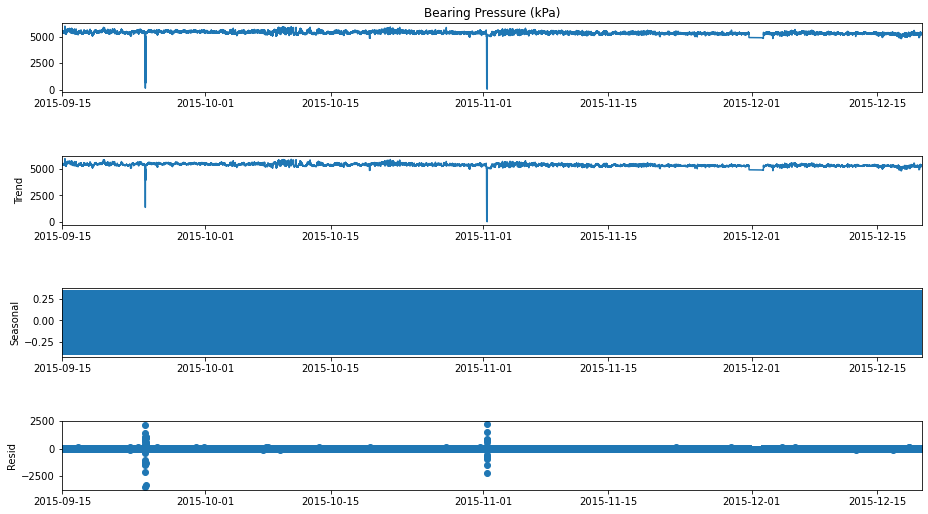

In [28]:
res = sm.tsa.seasonal_decompose(TrainData['Bearing Pressure (kPa)'].dropna(),freq=7)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

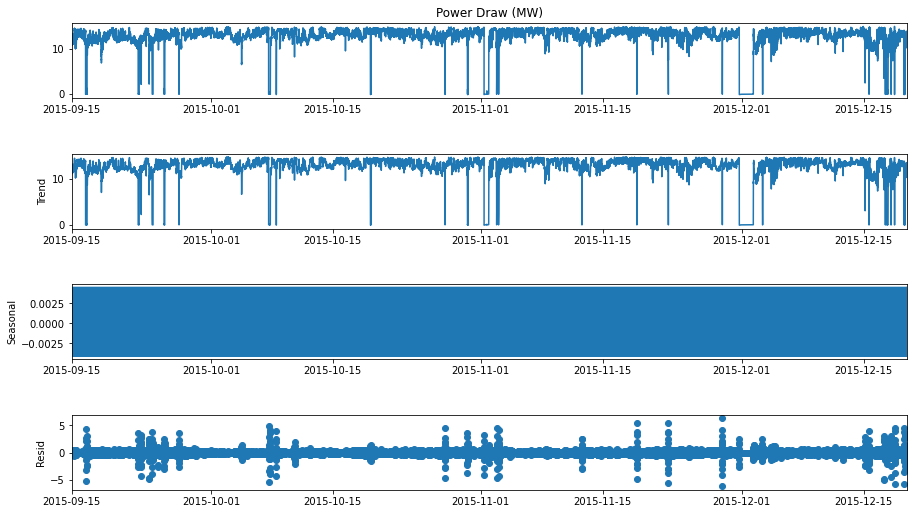

In [29]:
res = sm.tsa.seasonal_decompose(TrainData['Power Draw (MW)'].dropna(),freq=7)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

## 1-Identification 
### ACF and PACF for Bearing Pressure

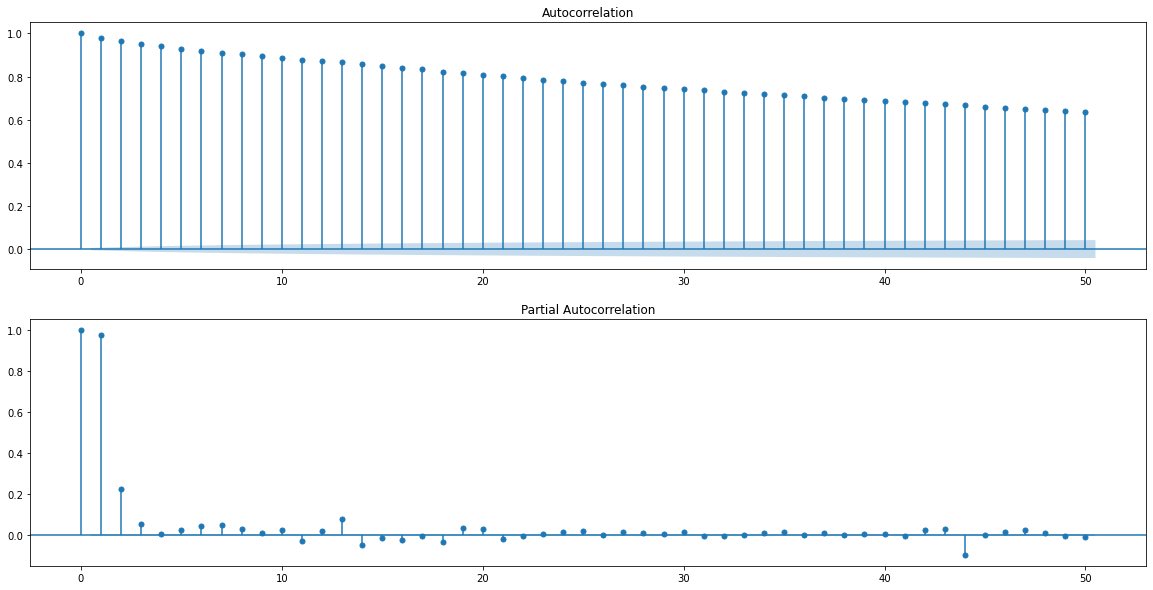

In [30]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(TrainData['Bearing Pressure (kPa)'].dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(TrainData['Bearing Pressure (kPa)'].dropna(), lags=50, ax=ax[1])
plt.show()

### ACF and PACF for Power Draw 

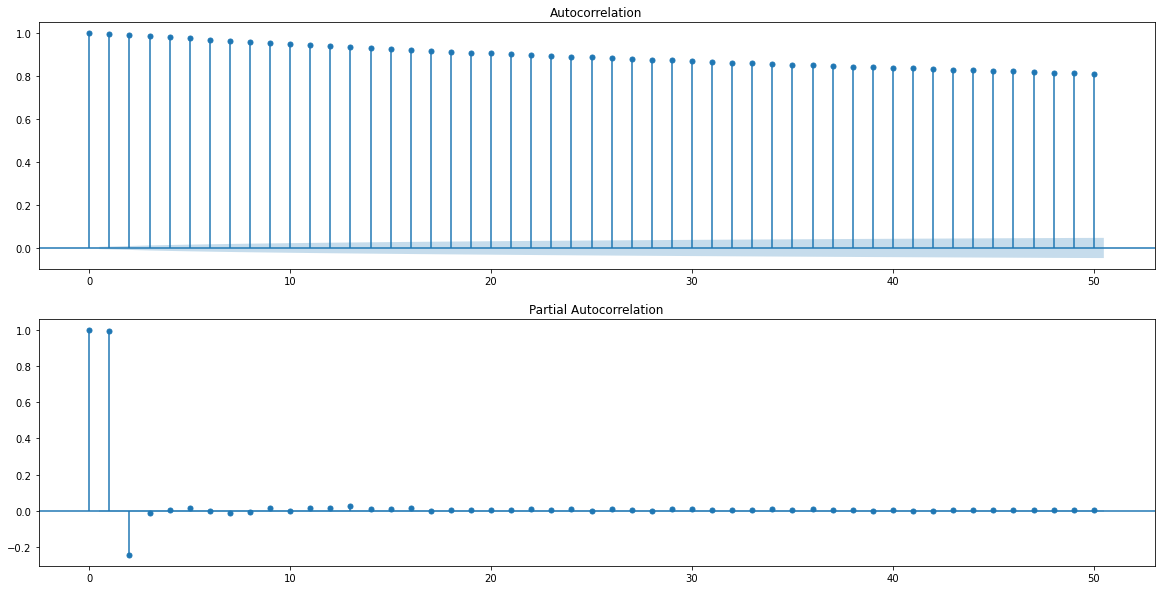

In [31]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(TrainData['Power Draw (MW)'].dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(TrainData['Power Draw (MW)'].dropna(), lags=50, ax=ax[1])
plt.show()

# 2-Identification
Augmented Dickey-Fuller (ADF) test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).

Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

If the null hypothesis can be rejected, we can conclude that the time series is stationary.

There are two ways to rejects the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

**p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

**p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.

**ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

**ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [34]:
# Run test
result = adfuller(TrainData['Bearing Pressure (kPa)'])

# Print test statistic
print(result[0])

# Print p-value
print(result[1])

# Print critical values
print(result[4]) 

-22.74706221322574
0.0
{'1%': -3.4303973298363197, '5%': -2.861560919109818, '10%': -2.5667811344990517}


# Interpreting the test result

The results object is a tuple. The zeroth element is the test statistic, in this case it is-22.74706221322574. The more negative this number is, the more likely that the data is stationary.

The next item in the results tuple, is the test p-value. Here it's 0.0. If the p-value is smaller than 0.05, we reject the null hypothesis and assume our time series must be stationary. 

The last item in the tuple is a dictionary. This stores the critical values of the test statistic which equate to different p-values. In this case, if we wanted a p-value of 0.05 or below, our test statistic needed to be below -2.86. 

In [36]:
# Run test
result = adfuller(TrainData['Bearing Pressure (kPa)'])

# Print test statistic
print(result[0])

# Print p-value
print(result[1])


-22.74706221322574
0.0


In [37]:
# Run test
result = adfuller(TrainData['Power Draw (MW)'])

# Print test statistic
print(result[0])

# Print p-value
print(result[1])


-15.437015306143836
2.8981083248542445e-28


In [38]:
# Run test
result = adfuller(TrainData['Speed (RPM)'])

# Print test statistic
print(result[0])

# Print p-value
print(result[1])


-14.953802000463734
1.2688472885704499e-27


In [39]:
# Run test
result = adfuller(TrainData['Power Draw (MW)'])

# Print test statistic
print(result[0])

# Print p-value
print(result[1])


-15.437015306143836
2.8981083248542445e-28


In [40]:
# Run test
result = adfuller(TrainData['Dilution Flow Rate (m3/h)'])

# Print test statistic
print(result[0])

# Print p-value
print(result[1])


-15.139634254022834
7.040884731902201e-28


In [41]:
# Run test
result = adfuller(TrainData['Conveyor Belt Feed Rate (t/h)'])

# Print test statistic
print(result[0])

# Print p-value
print(result[1])


-13.354688204377297
5.578891806992444e-25


In [42]:
TestData# Run test
result = adfuller(TrainData['Conveyor Belt PSD Fines (%)'])

# Print test statistic
print(result[0])

# Print p-value
print(result[1])


-16.68617135231367
1.5019172096515286e-29


# 3-Estimation
# Search best Param

In [33]:
resDiff = sm.tsa.arma_order_select_ic(TrainData['Bearing Pressure (kPa)'], max_ar=2, max_ma=2, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (2, 0) is the best.


In [34]:
resDiff = sm.tsa.arma_order_select_ic(TrainData['Power Draw (MW)'], max_ar=2, max_ma=2, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (2, 0) is the best.


# Automated model selection
## First Target :Power Draw (MW)

In [17]:
# Import pmdarima as pm
import pmdarima as pm
# Create auto_arima model
model1 = pm.auto_arima(TrainData['Power Draw (MW)'],exogenous=TrainData[['Bearing Pressure (kPa)',  'Speed (RPM)',
       'Dilution Flow Rate (m3/h)', 'Conveyor Belt Feed Rate (t/h)',
       'Conveyor Belt PSD Fines (%)']],
                      seasonal=False,
                       #m=7,
                      #d=0,
                       #D=1, 
                 	  max_p=2, 
                       max_q=2,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True)
                       
# Print model summary
print(model1.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-144059.702, Time=159.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-130857.887, Time=50.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-142541.212, Time=169.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-144349.230, Time=214.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-130857.399, Time=148.36 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-144389.809, Time=189.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-144458.329, Time=198.29 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-144451.788, Time=210.62 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-144376.112, Time=197.90 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-144460.467, Time=183.88 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-144392.294, Time=212.60 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-144540.725, Time=160.88 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-142543.322, Time=159.51 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0

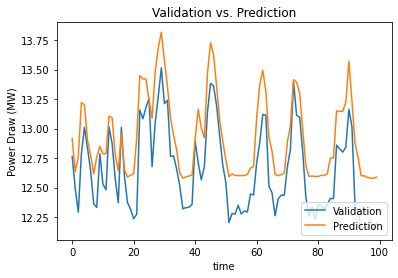

In [68]:
start_date=0
end_date=100
prediction = pd.DataFrame(model1.predict(n_periods = len(TestData[start_date:end_date]),
exogenous =TestData[['Bearing Pressure (kPa)',  'Speed (RPM)',
       'Dilution Flow Rate (m3/h)', 'Conveyor Belt Feed Rate (t/h)',
       'Conveyor Belt PSD Fines (%)']][start_date:end_date]),
index = TestData[start_date:end_date].index)
prediction=np.array(prediction)

plt.plot(TestData['Power Draw (MW)'][start_date:end_date].values)
plt.plot(prediction)
plt.xlabel('time')
plt.ylabel('Power Draw (MW)')
plt.legend(["Validation", "Prediction"], loc ="lower right") 
plt.title("Validation vs. Prediction")
plt.show()

In [61]:
prediction

array([[12.91467198],
       [12.6356167 ],
       [12.75987275],
       [13.22009732],
       [13.200807  ],
       [12.8968789 ],
       [12.7742567 ],
       [12.61585136],
       [12.75995066],
       [12.84936372]])

In [69]:
test=TestData['Power Draw (MW)'][start_date:end_date]
test.values

array([12.7620036 , 12.49153287, 12.2908877 , 12.78626847, 13.01026878,
       12.83133231, 12.6425888 , 12.36334374, 12.33074419, 12.78700524,
       12.52999983, 12.4800002 , 13.01291753, 12.87176847, 12.57631071,
       12.371184  , 13.00981211, 12.59848825, 12.37219236, 12.31496502,
       12.23562592, 12.27434863, 13.15642791, 13.08249467, 13.1771392 ,
       13.25607156, 12.67683362, 13.04757518, 13.27156576, 13.51361402,
       13.21060828, 13.23942531, 12.76377064, 12.76775775, 12.65493861,
       12.51270084, 12.31985697, 12.32923167, 12.33238214, 12.35863082,
       12.89339556, 12.71003965, 12.5645491 , 12.67735362, 13.13715485,
       13.38226225, 13.36038673, 13.19085296, 12.93215602, 12.6884357 ,
       12.54114157, 12.2028376 , 12.27958156, 12.27476755, 12.34948263,
       12.27527903, 12.30163853, 12.29276191, 12.4458796 , 12.43670097,
       12.70690744, 12.87912161, 13.11937969, 13.11319809, 12.51090822,
       12.45568419, 12.26062391, 12.40272285, 12.43570845, 12.43

In [70]:
mse = mean_squared_error(TrainData['Power Draw (MW)'][start_date:end_date], prediction)
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)
print('MSE: %f' % mse)

RMSE: 1.210386
MSE: 1.465034


# 4-Model diagnostics

In [48]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:               138241
Model:               SARIMAX(2, 1, 0)   Log Likelihood               72278.363
Date:                Sun, 28 Feb 2021   AIC                        -144540.725
Time:                        21:38:48   BIC                        -144462.031
Sample:                    09-15-2015   HQIC                       -144517.186
                         - 12-20-2015                                         
Covariance Type:                  opg                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Bearing Pressure (kPa)            0.0002   2.83e-06     55.818      0.000       0.000       0.000
Speed (RPM)                       1.4423      0.000   5129.971      0.000       1.442       1.443
Dilution Flow Rate (m3/h)      2.922e-05    2.8e-06     10.426      0.000    2.37e-05    3.47e-05
Conveyor Belt Feed Rate (t/h) -5.509e-05   7.62e-07    -72.316      0.000   -5.66e-05   -5.36e-05
Conveyor Belt PSD Fines (%)      -0.0003   5.32e-05     -4.861      0.000      -0.000      -0.000
ar.L1                            -0.3341      0.000  -1198.288      0.000      -0.335      -0.334
ar.L2                            -0.1204      0.000   -253.621      0.000      -0.121      -0.119
sigma2                            0.0206   7.48e-06   2751.661      0.000       0.021       0.021
===================================================================================
Ljung-Box (Q):                      885.72   Jarque-Bera (JB):        2969388385.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.76   Skew:                            -2.82
Prob(H) (two-sided):                  0.00   Kurtosis:                       720.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

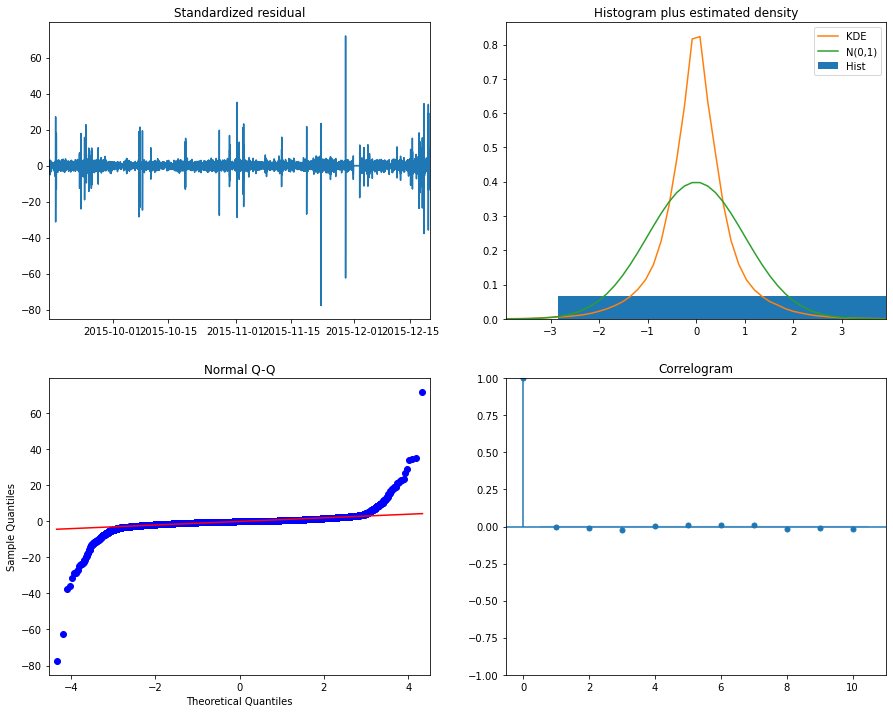

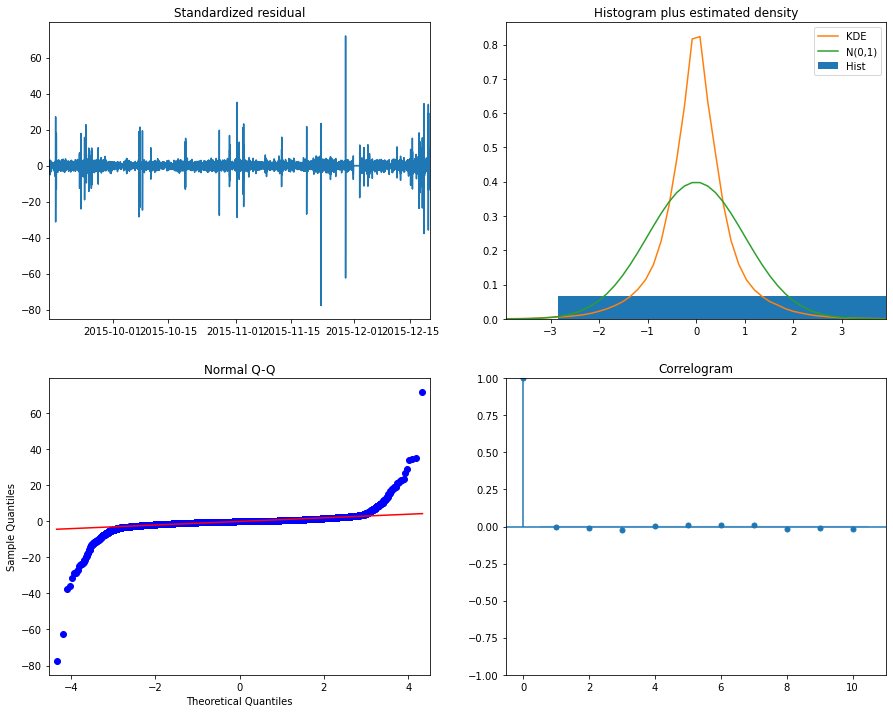

In [50]:
model1.plot_diagnostics(figsize=(15, 12))

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.
 
    
 

# Automation and saving

In [56]:
# Import joblib
import joblib

# Set model name

filename = "/home/abderrazak/ALLINHERE/NLP/Datacamp/model1Arima.pkl"

# Pickle it
joblib.dump(model1, filename)

['/home/abderrazak/ALLINHERE/NLP/Datacamp/model1Arima.pkl']

# Download the Model

In [ ]:
# Import
import joblib

# Set model name
filename = "candy_model.pkl"

# Load the model back in
loaded_model = joblib.load(filename)

In [ ]:
# Update the model

In [ ]:
# Update the model
loaded_model.update(df_new)